<a href="https://colab.research.google.com/github/eunseochu/YB_11th/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_%EC%82%AC%EC%9A%A9%EC%9E%90%ED%96%89%EB%8F%99%EC%9D%B8%EC%8B%9D%EC%98%88%EC%A0%9Cipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **결정 트리 실습 - 사용자 행동 인식 데이터 세트**
결정 트리를 이용해 UCI 머신러닝 리포지토리에서 제공하는 사용자 행동 인식 데이터 세트에 대한 예측 분류 수행
- 30명에서 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러 가지 피처를 수집한 데이터
- 수집된 피처 세트를 기반으로 결정 트리를 이용해 어떤 동작인지 예측

**1) 피처의 명칭 간략 확인** <br/>
인체의 움직임과 관련된 속성의 평균/표준편차가 X, Y, Z축 값으로 돼 있음

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리 되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('/content/sample_data/features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


**2-1) 중복된 피처명 확인** <br/>
feature.txt의 피처명과 features_info.txt 파일은 중복된 피처명을 가지고 있음 <br/>
중복된 피처명들을 이용해 데이터 파일을 데이터 세트 DataFrame에 로드하면 오류 발생

In [2]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


**2-2) 중복된 피처명 변경** <br/>
중복된 피처명에 대해서는 원본 피처명에_1 또는 _2를 추가로 부여하여, <br/>
새로운 피처명을 가지는 DataFrame을 반환하는 함수인 **get_new_feature_name_df()**를 생성

In [19]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis = 1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
  return new_feature_name_df

**3-1) 데이터 세트 로드** <br/>
train 디렉토리에 있는 학습용 피처 데이터 세트와 레이블 데이터 세트, <br/>
test 디렉토리에 있는 테스트용 피처 데이터 파일과 레이블 데이터 파일을 각각 학습/테스트용 DataFrame에 로드
- 공백으로 분리되어 있으므로 read_csv()의 sep 인자로 공백 문자 입력
- 레이블 칼럼은 'action'으로 명명
- DataFrame을 생성하는 로직을 간단한 함수 get_human_dataset()으로 생성
- get_new_feature_name_df()는 get_human_dataset() 내에서 적용돼 중복된 피처명을 새로운 피처명으로 할당

In [20]:
def get_human_dataset():

  # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
  feature_name_df = pd.read_csv('/content/sample_data/features.txt',sep='\s+', header=None,names=['column_index','column_name'])

  # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
 
  # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩, 칼럼명은 feature_name 적용
  X_train = pd.read_csv('/content/sample_data/X_train.txt', sep = '\s+', names = feature_name)
  X_test = pd.read_csv('/content/sample_data/X_test.txt', sep = '\s+', names = feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train = pd.read_csv('/content/sample_data/y_train.txt', sep = '\s+', header = None, names = ['action'])
  y_test = pd.read_csv('/content/sample_data/y_test.txt', sep = '\s+', header = None, names = ['action'])

  # 로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

**3-2) 학습용 피처 데이터 세트 살펴보기** <br/>
7352개의 레코드로 561개의 피처를 가지고 있음
- 피처가 전부 float 형의 숫자이므로 별도의 카테고리 인코딩 수행할 필요 없음
- 많은 칼럼의 대부분이 움직임의 위치와 관련된 속성

In [21]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [22]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


**3-3) 학습용 레이블 값 살펴보기** <br/>
레이블 값은 1, 2, 3, 4, 5, 6의 6개 값이고 분포도는 특정 값으로 왜곡되지 않고 비교적 고르게 분포돼 있음

In [24]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


**4) 동작 예측 분류 수행** <br/>
사이킷런의 DecisionTreeClassifier 이용
- DecisionTreeClassifier의 하이퍼 파라미터는 모두 디폴트 값으로 설정해 수행

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state = 156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


**5-1) 결정 트리의 트리 깊이(Tree Depth)가 예측 정확도에 주는 영향 살펴보기** <br/>
분류를 위해 리프 노드(클래스 결정 노드)가 될 수 있는 적합한 수준까지 지속해서 트리의 분할을 수행하면서 깊이가 깊어짐 <br/>
- GridSearchCV를 이용해 사이킷런 결정 트리의 깊이를 조절할 수 있는 하이퍼 파라미터인 max_depth 값을 변화
- max_depth를 6, 8, 10, 12, 16, 20, 24로 계속 늘리면서 예측 성능 측정
- 교차 검증은 5개 세트

In [33]:
# 5개의 CV 세트로 7개의 max_depth를 테스트

from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose = 1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.851344
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


**5-2) max_depth에 따른 예측 성능 확인** <br/>
5개의 CV 세트에서 max_depth 값에 따라 어떻게 예측 성능이 변했는지 GridSearchCV 객체의 **cv_results_** 속성 살펴보기 <br/>
- cv_results: CV 세트에 하이퍼 파라미터를 순차적으로 입력했을 때의 성능 수치
- mean_test_score: 5개의 CV 세트에서 검증용 데이터 세트의 정확도 평균 수치

In [35]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


결정 트리는 더 완벽한 규칙을 학습 데이터 세트에 적용하기 위해 노드를 지속적으로 분할하면서 깊이가 깊어지고 더욱 더 복잡한 모델이 됨 <br/>
깊어진 트리는 학습 데이터 세트에는 올바른 예측 결과를 가져올지 모르지만, 검증 데이터 세트에서는 오히려 과적합으로 인한 성능 저하 유발

**6) 별도의 테스트 데이터 세트에서 결정 트리의 정확도 측정** <br/>
별도의 테스트 데이터 세트에서 max_depth의 변화에 따른 값 측정

In [36]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
  dt_clf = DecisionTreeClassifier(max_depth = depth, random_state = 156)
  dt_clf.fit(X_train, y_train)
  pred = dt_clf.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


결정 트리는 깊이가 깊어질수록 과적합의 영향력이 커지므로 하이퍼 파라미터를 이용해 깊이 제어 필요 <br/>
복잡한 모델보다도 트리 깊이를 낮춘 단순한 모델이 더욱 효과적인 결과를 가져올 수 있음

**7) 정확도 성능 튜닝** <br/>
max_depth와 min_sample_split을 같이 변경하며 정확도 성능 튜닝

In [37]:
params = {
    'max_depth' : [8, 12, 16, 20],
    'min_samples_split': [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose = 1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCv 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCv 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


**8) 최적의 하이퍼 파라미터를 이용해 테스트 데이터 세트 예측 수행**

In [40]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

결정 트리 예측 정확도: 0.8717


**9) 각 피처의 중요도 살펴보기** <br/>
feature_importances_ 속성을 이용해 중요도가 높은 순으로 막대그래프 표현

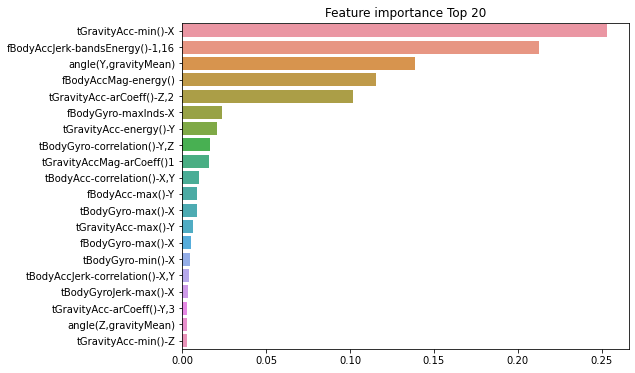

In [41]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, Seaborn의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]
plt.figure(figsize = (8,6))
plt.title('Feature importance Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()